# Simple Markowitz Portfolio Optimization

## Risk and Return
Markovitz *modern portfolio theory* is based on the understanding that investors are risk averse and thus will chose the one portfolio which has the highest (expected) return given a level of risk (measured as volatility) and, similarly, will chose the one with the lowest risk given a certain level of (required) return. 

Given an investment into $n$ assets a portfolio's (expected) return is given by

\begin{equation}
\mathbb{E}[r_p] = \sum_{i} w_i * \mathbb{E}[r_i] = \mathbf{w^T R}
\end{equation}

where $w_i \in [0,1]$ with $\sum_i w_i = 1$ is the proportion invested in asset $i$, $\mathbb{E}[r_i]$ asset $i$'s expected return, $\mathbf{w}$ and $\mathbf{R}$ are $n \times 1$ vectors with weights and historical returns, respectively. Note that we assume that historical returns are the best estimators for the expected return. 

In the same context, risk is defined as the the portfolio's return variance:

$$\sigma_p^2 = \sum_i \sum_j w_i w_j \sigma_i \sigma_j \rho_{ij} = \mathbf{w^T \Sigma w}$$

where $\sigma$ is the (sample) standard deviation of the periodic returns on an asset, $\rho_{ij}$ is the correlation coefficient between returns on asset $i$ and $j$ and $\mathbf{\Sigma}$ the corresponding matrix notation of the variance-covariance matrix.

## Load Data
Given a vector of weights, the portfolio return and volatility vary. In a first step, we download and prepare the data and plot charts. For our sample we take the share prices of Apple, Microsoft, Yahoo, Verizon and a Gold ETF.

In [1]:
# Import necessary packages
import numpy as np
import pandas_datareader.data as web  # to download share prices from web
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Define ticker, start, end for download
symbols = ['AAPL', 'MSFT', 'YHOO', 'VZ', 'GLD']
start   = dt.datetime(2016, 4, 26)
end     = dt.datetime(2017, 4, 25)
noa     = len(symbols)  # Number of assets (here 5)

# Download closing prices of defined shares
data = pd.DataFrame()
for sym in symbols:
    data[sym] = web.DataReader(sym, 'google', start, end)['Close']

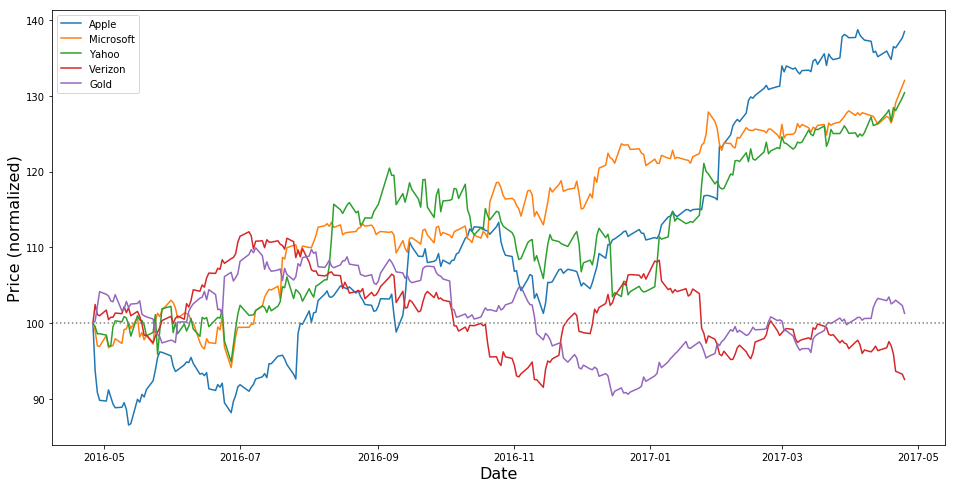

In [2]:
# Normalize prices to 100 and plot 
plt.figure(figsize = (16, 8))
plt.plot(data / data.iloc[0, :] * 100)
plt.axhline(y=100, color='gray', linestyle=':')
plt.legend(['Apple', 'Microsoft', 'Yahoo', 'Verizon', 'Gold'])
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price (normalized)', fontsize=16)

## Portfolio Simulation

We simulate 5'000 random portfolios. For this we generate 5'000 times a vector `w` containing a weight for each asset (with $\sum_i w_i = 1$) and calculate the (annualized) return (`pfrets`) and volatility (`pfvols`) for each random portfolio/set of weights.

In [3]:
# Calculate the log-returns
rets = np.log(data / data.shift(periods=1))

nos = 5000   # Number of simulations
pfrets = []  # Portfolio returns
pfvols = []  # Portfolio volatilities
rf = 0.023   # Risk-free rate

# Simulate 'nos' times 'nas' random weights and calculate corresponding
# (annual) portfolio return and volatility given the random weights
for p in range(nos):
    w = np.random.random(noa)
    w = w / np.sum(w)
    pfrets.append(np.sum(rets.mean() * w) * 252)
    pfvols.append(np.sqrt(np.dot(w.T, np.dot(rets.cov() * 252, w))))

# Convert results to an np.array
pfrets = np.array(pfrets)
pfvols = np.array(pfvols)

Having generated 5'000 portfolios and calculated the return and volatiliy for each of these random portolio we use a scatter plot to visualize the result. We apply a color scheme to indicate the Sharpe ratio ($SR$) of each portfolio, where the Sharpe ratio is defined as 

$$SR_p = \frac{\mathbb{E}[r_p] - r_f}{\sigma_p} $$

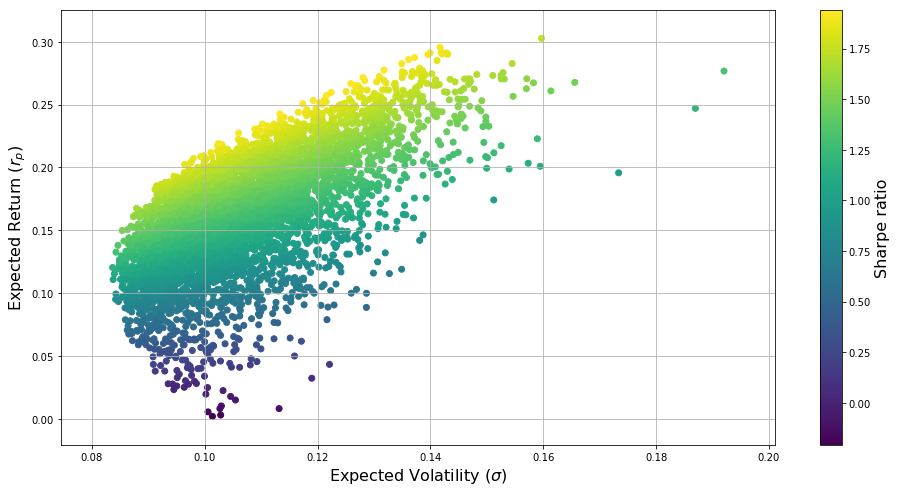

In [4]:
# Plot 
plt.figure(figsize = (16, 8))
plt.scatter(pfvols, pfrets, c=(pfrets-rf) / pfvols, marker='o')
plt.grid(True)
plt.xlabel('Expected Volatility ($\sigma$)', fontsize=16)
plt.ylabel('Expected Return ($r_p$)', fontsize=16)
plt.colorbar().set_label(label='Sharpe ratio', size=16)

## Portfolio Optimization 

### Optimal Portfolio

We're now in a position to investigate how we can find the optimal risky portfolio. From the above figure it should be clear that we ought to find the optimal weights witch the steepest capital allocation line (CAL). Since the slope of the CAL is equal to the Sharpe ratio, we find our solution by maximizing the Sharpe ratio with respect to the portfolio weights:

$$\max_{w_i} SR_p = \frac{\mathbb{E}[r_p] - r_f}{\sigma_p} \quad s.t. \quad \sum_i w_i = 1 \qquad \Leftrightarrow \qquad \max_{w_i} SR_p = \frac{\mathbf{w^T R} - r_f}{\mathbf{w^T \Sigma w}} \quad s.t. \quad \sum_i w_i = 1 $$

We could solve this analytically using matrix algebra (e.g. with Lagrange) but this gets fairly complicated. With Python at hand, there's a much easier way to solves this opimization problem numerically. For this we first define an auxiliary function that returns the portfolio return, volatility and Sharpe ratio given a vector of weights. Note that the function also makes use of other data like daily returns and the riskfree rate as previously defined but only `weights` are an function input. This is necessary for the optimization function. 

In [5]:
def pfStats(weights):
    '''Returns basic measures for a portfolio
    
    Parameters
    ==========
    weights : array-like
        weights for different securities in portfolio
    
    Returns
    =======
    pfret : float
        portfolio return
    pfvol : float
        portfolio volatility
    SR : float
        portfolio Sharpe ratio for given riskfree rate
    '''
    
    pfret = np.sum(rets.mean() * weights) * 252
    pfvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
    SR    = (pfret - rf) / pfvol 
    
    return np.array([pfret, pfvol, SR])
    

Python's ```scipy``` package has a sublibrary for constrained optimization problems. We will use the ```minimize``` function and minimize the negative value of the Sharpe ratio (which is obviously equal to maximizing the SR). 

In [6]:
import scipy.optimize as sco

def minSR(weights):
    return -pfStats(weights)[2]

As defined above, we have the constraint that $\sum_i w_i = 1$. Let's further assume short selling is not allowed, so that $w_i \in [0, 1]\, \forall i \in [1, 2, \ldots, n]$. 

In [7]:
constr = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # constraint: sum of weights - 1 = 0
bnds   = tuple((0,1) for x in range(noa))  # bounds: each weight has to be in [0, 1]
swghts = np.repeat(1. / noa, noa)  # start weights (equally spread)

# Minimization function
optPf = sco.minimize(minSR, x0=swghts, method='SLSQP', bounds=bnds, constraints=constr)

# Results
rsltsOptPf = pfStats(optPf['x'])

print(optPf)
print('\n')
print('Portfolio return:     {0: 1.4f}'.format(rsltsOptPf[0]))
print('Portfolio volatility: {0: 1.4f}'.format(rsltsOptPf[1]))
print('Portfolio SR:         {0: 1.4f}'.format(rsltsOptPf[2]))
print('Asset weights:        ', str(optPf['x']))

     fun: -1.958251575512082
     jac: array([-0.19435322, -0.19734393, -0.19694398,  1.25363258, -0.19512242])
 message: 'Optimization terminated successfully.'
    nfev: 52
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([ 0.36512023,  0.40533232,  0.06897677,  0.        ,  0.16057068])


Portfolio return:      0.2530
Portfolio volatility:  0.1174
Portfolio SR:          1.9583
Asset weights:         [ 0.36512023  0.40533232  0.06897677  0.          0.16057068]


### Minimum Variance Portfolio

Similar to the optimal risky portfolio above we calcualte the minimum variance portfolio. This time, however, we will minimize the variance. The constraints remain as before for the optimal risky portfolio.

In [8]:
# Auxiliary function
def minVar(weights): 
    return pfStats(weights)[1] ** 2

# Minimization function
minVarPf = sco.minimize(minVar, x0=swghts, method='SLSQP', bounds=bnds, constraints=constr)

# Results
rsltsMinVarPf = pfStats(minVarPf['x'])

print('Portfolio return:     {0: 1.4f}'.format(rsltsMinVarPf[0]))
print('Portfolio volatility: {0: 1.4f}'.format(rsltsMinVarPf[1]))
print('Portfolio SR:         {0: 1.4f}'.format(rsltsMinVarPf[2]))
print('Asset weights:        ', str(minVarPf['x']))

Portfolio return:      0.1133
Portfolio volatility:  0.0832
Portfolio SR:          1.0853
Asset weights:         [ 0.14834022  0.23721707  0.01631526  0.15006928  0.44805817]


## Efficient Frontier

The efficient frontier represents those portfolios with the lowest possible variance that can be attained for a given portfolio expected return. In that sense, we can derive this similarly to the previous optimizations. What changes, however, is the fact that now we are looking for a *set* of portfolios instead of just one. For that we define an interval of target return levels, based on which the optimization function searches for the weights which lead to the lowest portfolio variance. With that we have now two constraints. 

Note: In a strict sense, the efficient frontier only captures portfolios with returns equal or above the global minimum variance portfolio. Therefore, the interval starts at that point.

In [9]:
tarRet = np.linspace(start=rsltsMinVarPf[0], stop=0.30, num=100)  # Target returns

tarVols = []
for i in tarRet:
    constr = ({'type': 'eq', 'fun': lambda x: pfStats(x)[0] - i},  
              {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    effFront = sco.minimize(minVar, x0=swghts, method='SLSQP', bounds=bnds, constraints=constr)
    tarVols.append(effFront['fun'])
    
tarVols = np.array(np.sqrt(tarVols))


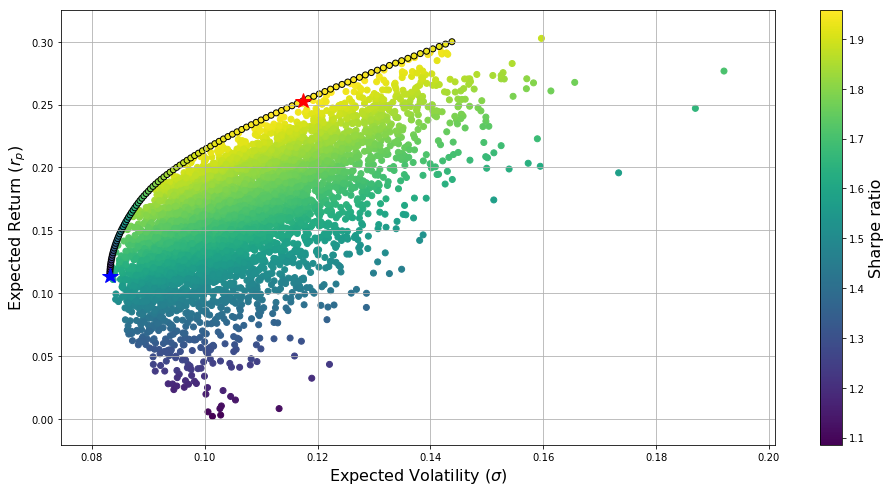

In [10]:
# Plot 
plt.figure(figsize = (16, 8))
plt.scatter(pfvols, pfrets, c=(pfrets-rf) / pfvols, marker='o')    # Random porfolios
plt.scatter(tarVols, tarRet, c=(tarRet-rf) / tarVols, 
            marker='o', edgecolors='black')                        # Efficient frontier
plt.plot(rsltsOptPf[1], rsltsOptPf[0], 'r*', markersize=16)        # Optimal risky portfolio
plt.plot(rsltsMinVarPf[1], rsltsMinVarPf[0], 'b*', markersize=16)  # Minimum variance portfolio
plt.grid(True)
plt.xlabel('Expected Volatility ($\sigma$)', fontsize=16)
plt.ylabel('Expected Return ($r_p$)', fontsize=16)
plt.colorbar().set_label(label='Sharpe ratio', size=16)

### Capital Market Line

The capital market line is a linear function on which all efficient portfolio must lie. As such it can be expressed as

$$ f(\sigma) = r_f + \left( \frac{r_{opf} - r_f}{\sigma_{opf}} \right) \sigma $$

where $r_{opf}$ is the return of the optimal portfolio and $\sigma_{opf}$ is the volatility of the optimal portfolio. The proportions of investment into the riskfree asset and the optimal risky portfolio depend on the investor's risk aversion. The function's intercept equals the risk free rate and it is tangential to the optimal risky portfolio. With that, the slope equals the respective Sharpe ratio. 

All portfolio along the capital market line are attainable.

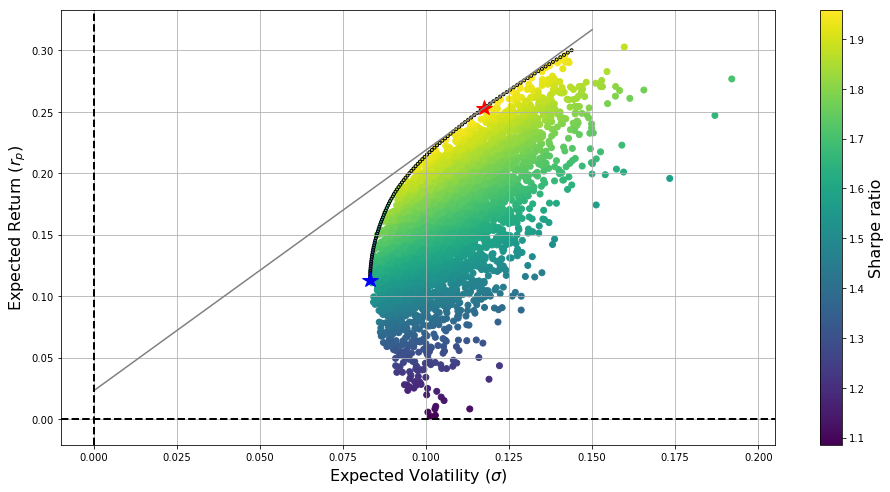

In [11]:
# Calculate values of CML
sigma = np.array([0, 0.15])
cml = rf + rsltsOptPf[2] * sigma

# Plot 
plt.figure(figsize = (16, 8))
plt.scatter(pfvols, pfrets, c=(pfrets-rf) / pfvols, marker='o')    # Random porfolios
plt.scatter(tarVols, tarRet, c=(tarRet-rf) / tarVols, 
            marker='.', edgecolors='black')                        # Efficient frontier
plt.plot(rsltsOptPf[1], rsltsOptPf[0], 'r*', markersize=16)        # Optimal risky portfolio
plt.plot(rsltsMinVarPf[1], rsltsMinVarPf[0], 'b*', markersize=16)  # Minimum variance portfolio
plt.plot(sigma, cml, color='gray')                                 # Capital market line
plt.axhline(0, color='k', ls='--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)
plt.grid(True)
plt.xlabel('Expected Volatility ($\sigma$)', fontsize=16)
plt.ylabel('Expected Return ($r_p$)', fontsize=16)
plt.colorbar().set_label(label='Sharpe ratio', size=16)

## Further Reading

- Markowitz, Harry M., 1952, *Portfolio selection*, The Journal of Finance 7, 77-91.
- Bodie, Zvie, Alex Kane, and Alan Marcus, 2014, *Investments* (McGraw-Hill, New York City, NY).
- Hilpisch, Yves, 2015, *Python for Finance* (O'Reilly Media, Sebastopol, CA).